# Comparison NRTidalv2 against gwfast

**Abstract**: This notebook compares the results of the NRTidalv2 implementation in ripple to the results of the gwfast implementation. You need to have the gwfast package installed to run this notebook. To do so, run
```bash
pip install gwfast
```

In [953]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
from jax import grad, vmap
from functools import partial
jax.config.update("jax_enable_x64", True)

from ripple.waveforms import IMRPhenomD
from ripple import ms_to_Mc_eta, lambdas_to_lambda_tildes
from ripple.constants import MSUN, gt, PI
from ripple.waveforms.utils_tidal import get_quadparam_octparam
from ripple import get_eff_pads
from ripple.waveforms import X_NRTidalv2

import lalsimulation as lalsim
import lal

from gwfast.waveforms import IMRPhenomD_NRTidalv2 as gwfast_IMRPhenomD_NRTidalv2

import numpy as np
import matplotlib.pyplot as plt
params = {"axes.grid": True,
        "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

If you want, you can load the worst mismatch and get the parameters from there.

In [954]:
load_bad_match = True
if load_bad_match:
    csv_file = "../test/matches_data/check_IMRPhenomD_NRTidalv2_matches.csv"
    # load with pandas
    import pandas as pd
    df = pd.read_csv(csv_file)
    df = df.dropna()
    # Get the first entry, and fetch masses, spins, tidal parameters
    m1 = df["m1"].values[0]
    m2 = df["m2"].values[0]
    chi1 = df["chi1"].values[0]
    chi2 = df["chi2"].values[0]
    lambda1 = df["lambda1"].values[0]
    lambda2 = df["lambda2"].values[0]
else:
    # Put your desired parameters here and toggle load_bad_match to False
    m1 = 2
    m2 = 1.5

    chi1 = 0.5
    chi2 = 0.5

    lambda1 = 400
    lambda2 = 400

print("m1 = ", m1)
print("m2 = ", m2)
print("chi1 = ", chi1)
print("chi2 = ", chi2)
print("lambda1 = ", lambda1)
print("lambda2 = ", lambda2)
distance = 40.

m1 =  0.561872066570538
m2 =  0.5143849471969018
chi1 =  -0.4718170602892759
chi2 =  0.3662686244925731
lambda1 =  4455.227358172733
lambda2 =  3767.957814581541


Get the frequency grid:

In [955]:
# Frequency grid
T = 16
f_l = 20.0
f_sampling = 2 * 2048
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [956]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = 0
polarization_angle = 0.0

# Convert from source values to sample values
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(jnp.array([lambda1, lambda2, m1, m2]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda_tilde, delta_lambda_tilde, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]
print(fs_ripple)

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs_ripple, theta_ripple, f_ref)

[  20.0625   20.125    20.1875 ... 2047.8125 2047.875  2047.9375]
f_merger
0.014874390411938956
0.014874390411938956
fring
0.08588654705551063
fdamp
0.013718248946390055
f_ref
0.00010602188524979706


## LAL

In [957]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
# print(quad1)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# print(oct1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)

IMRphenom = "IMRPhenomD_NRTidalv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]
# One frequency variable, just f
f = freqs_lal[mask_lal]
print(np.allclose(f, fs_ripple))

True


## GWfast

In [958]:
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
# Convert given distance to a redshift
redshift = z_at_value(cosmo.comoving_distance, dist_mpc * u.Mpc)
redshift = redshift.value

In [959]:
gwfast_kwargs = {"Mc": Mc, 
                 "eta": eta,
                 "chi1z": chi1,
                 "chi2z": chi2,
                 "Lambda1": lambda1,
                 "Lambda2": lambda2,
                 "dL": dist_mpc * 1e-3, # to convert to Gpc
                 "tcoal": tc,
                 "Phicoal": phic,
                 }
gwfast_object = gwfast_IMRPhenomD_NRTidalv2(fRef=f_ref)
gwfast_amp = gwfast_object.Ampl(freqs, **gwfast_kwargs)
gwfast_phi = gwfast_object.Phi(freqs, **gwfast_kwargs)
gwfast_complex = gwfast_amp * jnp.exp(-1j * gwfast_phi)

# Convert to polarizations
hp_gwfast = gwfast_complex * (1 / 2 * (1 + jnp.cos(inclination) ** 2))
mask_gwfast = (freqs > f_l) & (freqs < f_u)
new_freqs = freqs[mask_gwfast]
print(np.allclose(new_freqs, f))
hp_gwfast = hp_gwfast[mask_gwfast]

f_merger
0.01487439041193896
fring
0.08588661303454768
fdamp
0.013718251519057484
self.fRef
20.0
fRef
0.00010602188524979708
True


## Comparison

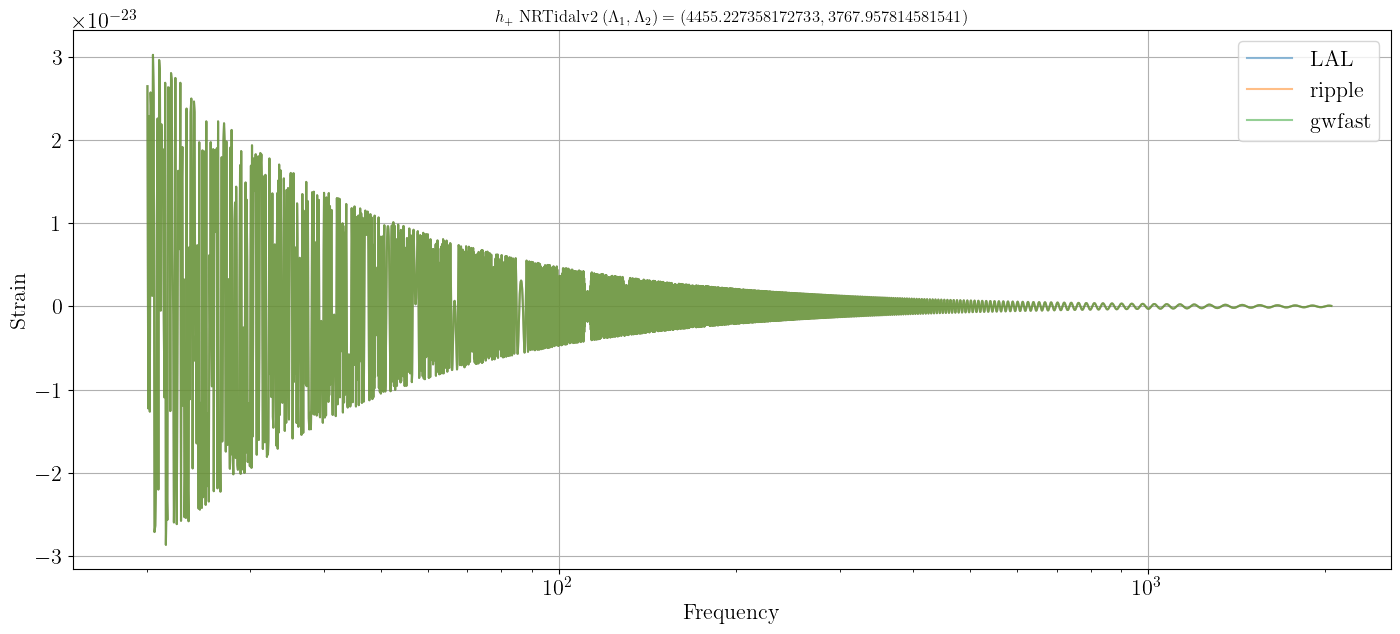

In [960]:
a = 0.5
plt.subplots(1, 1, figsize=(17, 7))

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.plot(f, hp_gwfast.real, "-", label = "gwfast", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

f_merger
0.01487439041193896
f_merger =  2805.9094359421288


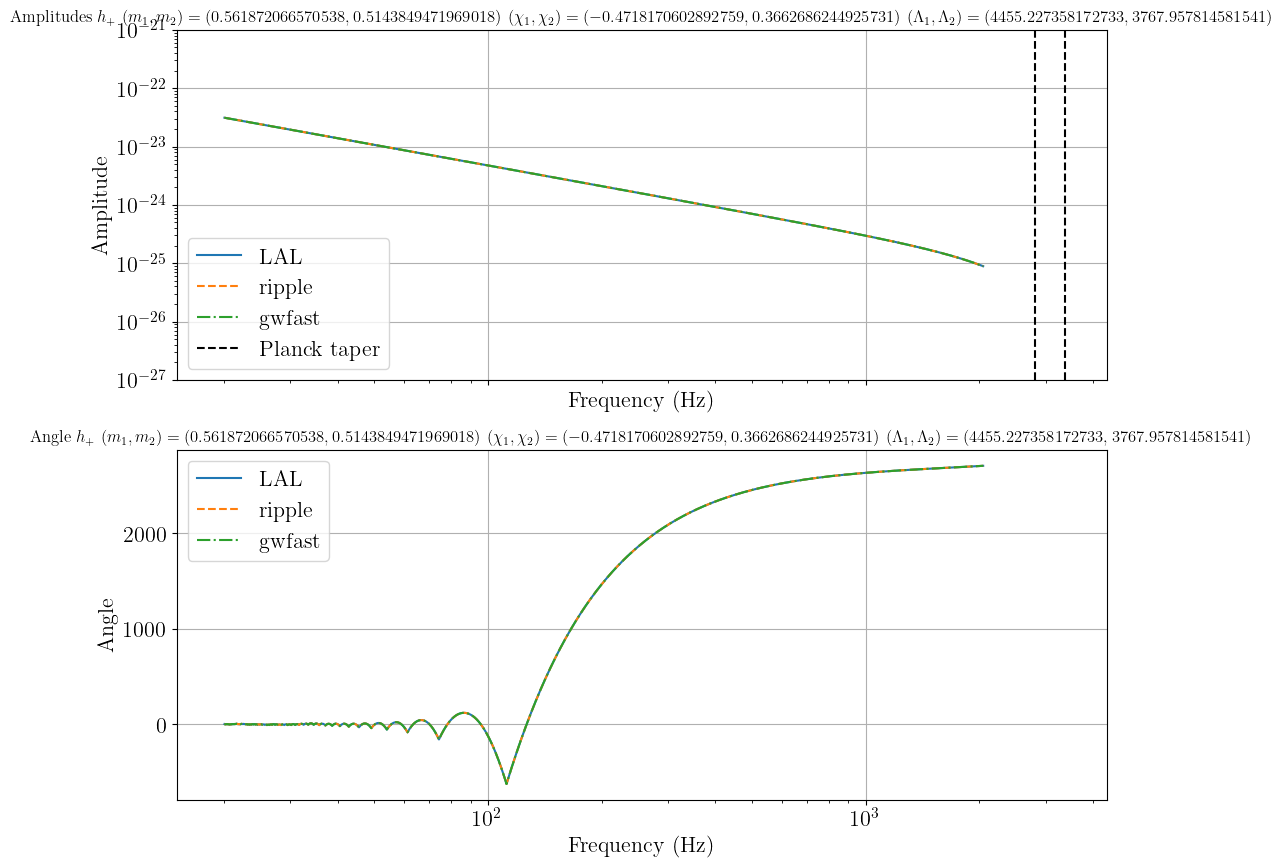

In [961]:
## Get the merger frequency to check the Planck taper window

l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])

my_theta = jnp.array([m1, m2, chi1, chi2, lambda1, lambda2])
f_merger = X_NRTidalv2._get_f_merger(my_theta, physical=True)
f_merger = float(f_merger)
print("f_merger = ", f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

A_gwfast = jnp.abs(hp_gwfast)
angle_gwfast = np.unwrap(np.angle(hp_gwfast))
phase_gwfast = hp_gwfast / A_gwfast

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(f, A_lalsuite, "-", label = "LAL")
plt.plot(f, A_ripple, "--", label = "ripple")
plt.plot(f, A_gwfast, "-.", label = "gwfast")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(f, angle_lalsuite, "-", label = "LAL")
    plt.plot(f, angle_ripple, "--", label = "ripple")
    plt.plot(f, angle_gwfast, "-.", label = "gwfast")
    name = "Angle"
else:
    plt.plot(f, angle_lalsuite, "-", label = "LAL")
    plt.plot(f, phase_ripple, "--", label = "ripple")
    plt.plot(f, phase_gwfast, "-.", label = "gwfast")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

## Differences: ripple vs lal

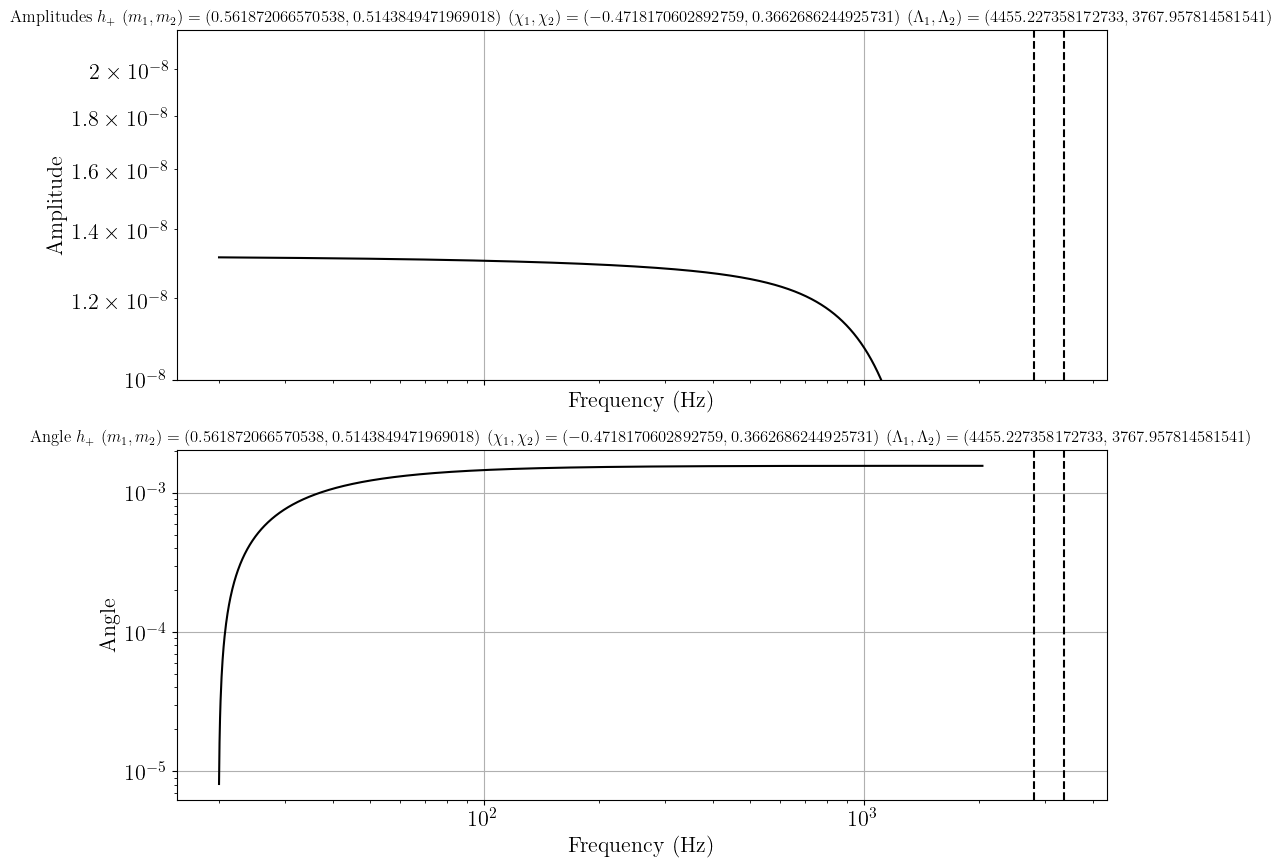

In [962]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple) / A_lalsuite
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(bottom = 1e-8)

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
# plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale('log')
plt.show()

## Differences: gwfast vs lal

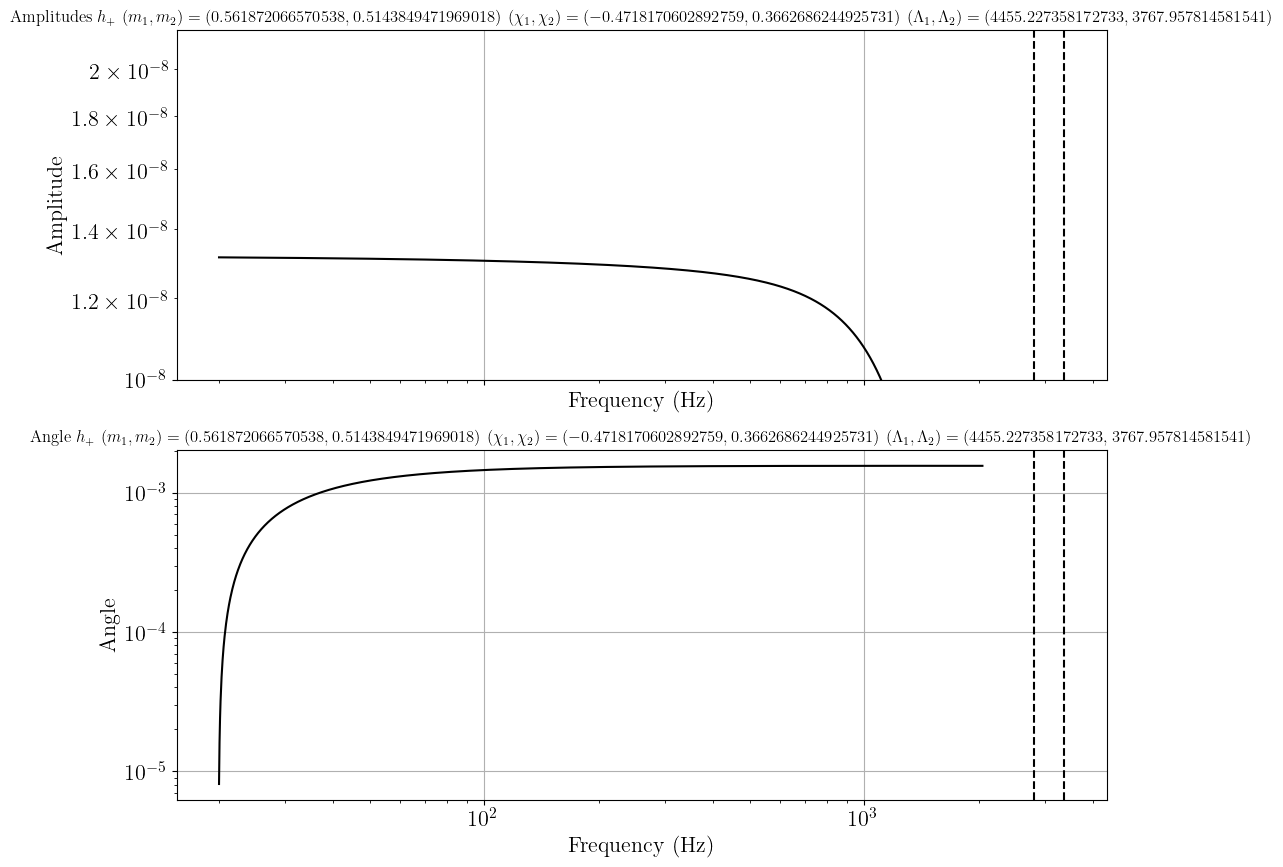

In [963]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_gwfast) / A_lalsuite
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(bottom = 1e-8)

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_gwfast), "-", color = 'black')
name = "Angle"
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
# plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale('log')
plt.show()

## Differences: ripple vs gwfast

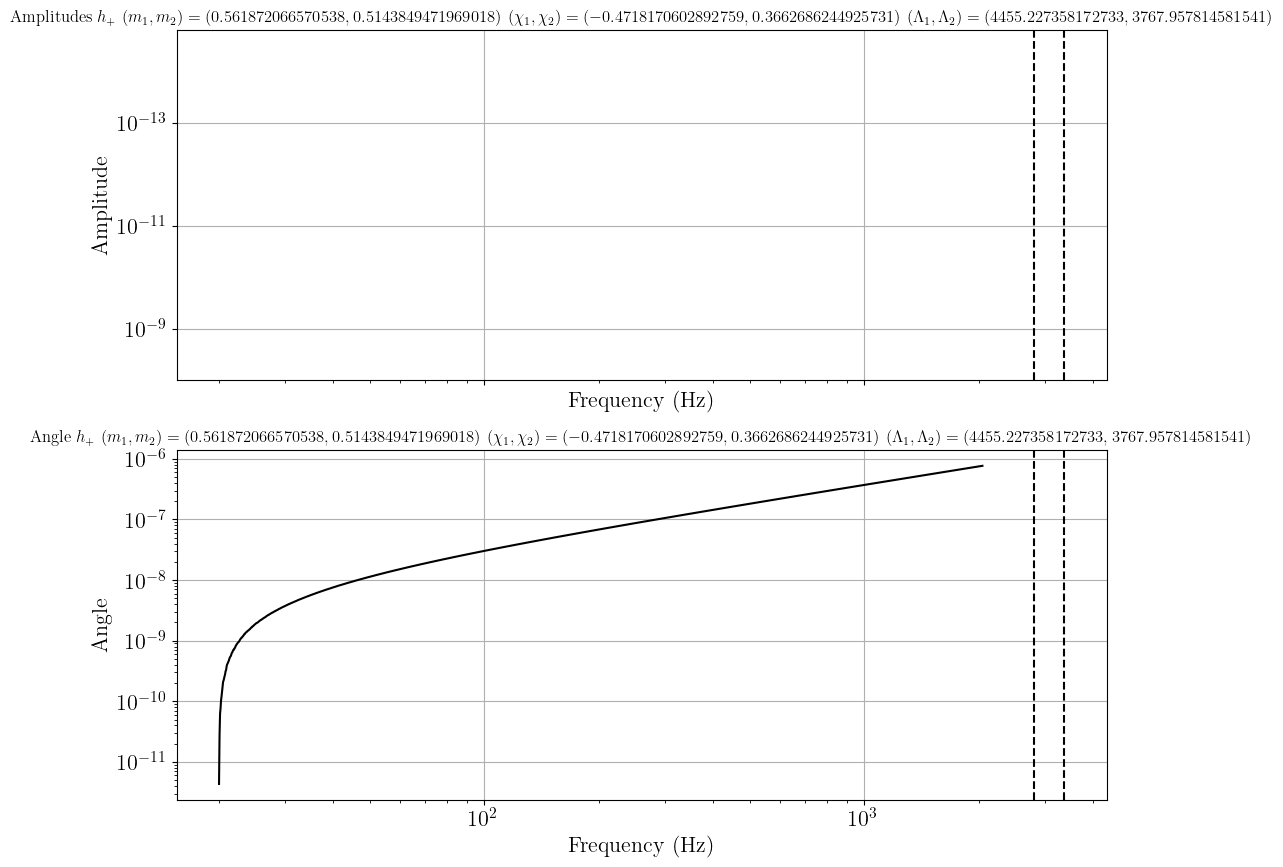

In [964]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_gwfast - A_ripple) / A_gwfast
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(bottom = 1e-8)

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_gwfast - angle_ripple), "-", color = 'black')
name = "Angle"
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
# plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale('log')
plt.show()

## Computing mismatch

In [965]:
from ripple import get_match_arr

In [966]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match_ripple = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_ripple,
        hp_lalsuite,
)

match_gwfast = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_gwfast,
        hp_lalsuite,
)

print("Ripple")
print(np.log10(1 - match_ripple))
print("gwfast")
print(np.log10(1 - match_gwfast))

Ripple
-7.594545586492014
gwfast
-7.594632814278507


# Debugging

Idea is to show here some effort in trying to understand what part of the code is breaking down